<a href="https://colab.research.google.com/github/Omerizdn/Churn/blob/main/FOR_FINAL_SUBMISSION_IN_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-3-6946299ed764>:53: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataset.corr()


Random Forest Model
Accuracy: 0.619732046609517
Precision: 0.6164495949133422
Recall: 0.6210352309122843
F1 Score: 0.6197357259746087


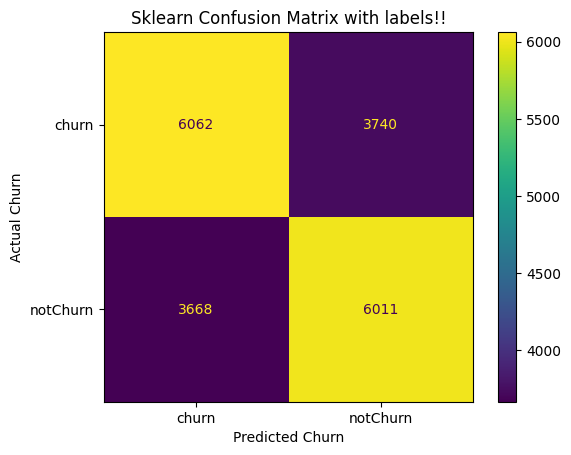

[LightGBM] [Info] Number of positive: 38723, number of negative: 39199
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5739
[LightGBM] [Info] Number of data points in the train set: 77922, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496946 -> initscore=-0.012217
[LightGBM] [Info] Start training from score -0.012217
Light GBM Model
Accuracy: 0.6391869000564653
Precision: 0.6337573187966888
Recall: 0.6486207252815374
F1 Score: 0.6391644544482391


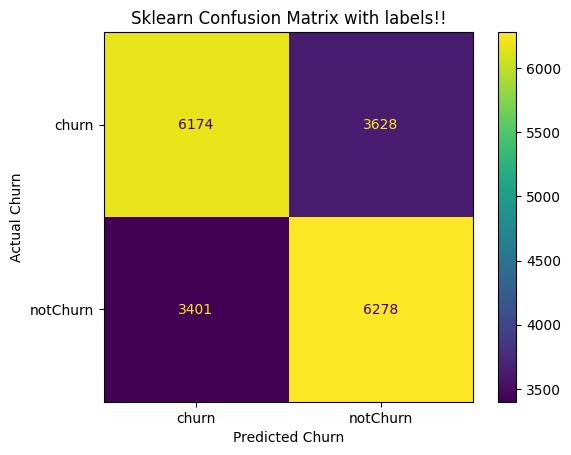

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Read data
df = pd.read_csv('/content/Telecom_Churn.csv')

# Function to handle missing values
def fill_missing_values(df):
    numerical_features = ['avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean']
    df[numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())
    df['hnd_webcap'] = df['hnd_webcap'].fillna('UNKW')
    return df.dropna()

# Remove unnecessary columns
df.drop(['numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod'], axis=1, inplace=True)

# Handle missing values
df = fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat = []
for feature in df.columns:
    predominant = (df[feature].value_counts()/len(df)).sort_values(ascending=False).values[0]
    if predominant > 0.998:
        quasi_constant_feat.append(feature)

df.drop(columns=quasi_constant_feat, inplace=True)

# Remove duplicated features
duplicated_feat = []
for i in range(0, len(df.columns), 10):
    col_1 = df.columns[i]
    for col_2 in df.columns[i+1:]:
        if df[col_1].equals(df[col_2]):
            duplicated_feat.append(col_2)

df.drop(columns=duplicated_feat, inplace=True)

# Remove correlated features
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

corr_features = correlation(df, 0.8)
df = df.drop(columns=corr_features)

# Categorical Encoding
def encode_categorical_features(df, encoding_method):
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        df[col] = encoding_method(df[col])
    return df

# Count Encoding
def count_encoding(col):
    counts_map = col.value_counts().to_dict()
    return col.map(counts_map)

# Ordinal Encoding
def ordinal_encoding(col):
    ordered_labels = col.groupby(col).mean().sort_values().index
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    return col.map(ordinal_label)

# Mean Encoding
def mean_encoding(col):
    ordered_labels = col.groupby(col).mean().to_dict()
    return col.map(ordered_labels)

df = encode_categorical_features(df, count_encoding)
df = encode_categorical_features(df, ordinal_encoding)
df = encode_categorical_features(df, mean_encoding)

# Split data
X = df.drop(labels=['Customer_ID', 'churn'], axis=1)
y = df['churn']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

# Modeling function
def modeling(alg, alg_name, params={}):
    model = alg(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    print(f'{alg_name} Model')
    print(f'Accuracy: {accuracy_score(y_valid, y_pred)}')
    print(f'Precision: {precision_score(y_valid, y_pred)}')
    print(f'Recall: {recall_score(y_valid, y_pred)}')
    print(f'F1 Score: {f1_score(y_valid, y_pred, average="weighted")}')

    cm = confusion_matrix(y_valid, y_pred)
    cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['churn', 'notChurn'])
    cmd_obj.plot()
    cmd_obj.ax_.set(title='Sklearn Confusion Matrix with labels!!', xlabel='Predicted Churn', ylabel='Actual Churn')
    plt.show()

# Random Forest Classifier Model
modeling(RandomForestClassifier, 'Random Forest')

# LightGBM model
modeling(lgbm.LGBMClassifier, 'Light GBM', {'n_estimators': 100, 'random_state': 42})

In [6]:
# Load necessary libraries
#library(data.table)
#install.packages("devtools")
#install.packages("randomForest")
#install.packages("lightgbm")
#install.packages("caret")
#library(caret)

# Set data.table options
options(datatable.print.class = TRUE)

# Read data
df <- fread('Telecom_Churn.csv')

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm=TRUE), x)), .SDcols=numerical_features]
  df[, 'hnd_webcap' := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df), ])
}

# Remove unnecessary columns
df <- df[, c('Customer_ID', 'churn') := NULL]
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- names(df)[sapply(df, function(x) sum(table(x)/length(x)) > 0.998)]
df <- df[, ..quasi_constant_feat := NULL]

# Remove duplicated features
duplicated_feat <- vector('character')
for (i in seq(1, length(df), 10)) {
  col_1 <- names(df)[i]
  for (col_2 in names(df)[(i+1):length(df)]) {
    if (all(df[[col_1]] == df[[col_2]])) {
      duplicated_feat <- c(duplicated_feat, col_2)
    }
  }
}
df <- df[, ..duplicated_feat := NULL]

# Remove correlated features
correlation <- function(dataset, threshold) {
  numeric_cols <- sapply(dataset, is.numeric)
  numeric_data <- dataset[, numeric_cols, with = FALSE]
  col_corr <- character()
  corr_matrix <- cor(numeric_data)
  for (i in seq_along(corr_matrix)) {
    for (j in seq(i)) {
      if (abs(corr_matrix[i,j]) > threshold) {
        colname <- colnames(corr_matrix)[i]
        col_corr <- c(col_corr, colname)
      }
    }
  }
  return(unique(col_corr))
}

corr_features <- correlation(df, 0.8)
df <- df[, ..corr_features := NULL]

# Categorical Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %>% as.character() %>% map_chr(counts_map))
}

ordinal_encoding <- function(col) {
  ordered_labels <- as.character(col %>% tapply(mean) %>% sort)
  ordinal_label <- setNames(seq_along(ordered_labels)-1, ordered_labels)
  return(col %>% as.character() %>% map_chr(ordinal_label))
}

mean_encoding <- function(col) {
  ordered_labels <- as.character(col %>% tapply(mean))
  ordered_labels <- setNames(ordered_labels, ordered_labels)
  return(col %>% as.character() %>% map_chr(ordered_labels))
}

encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)
split_indices <- createDataPartition(df$churn, p=0.8, list=FALSE)
train_data <- df[split_indices,]
valid_data <- df[-split_indices,]

X_train <- train_data[, ..c('Customer_ID', 'churn') := NULL]
y_train <- train_data$churn
X_valid <- valid_data[, ..c('Customer_ID', 'churn') := NULL]
y_valid <- valid_data$churn

# Standardize data
sc <- preProcess(X_train, method=c('center', 'scale'))
X_train <- predict(sc, X_train)
X_valid <- predict(sc, X_valid)

# Modeling function
modeling <- function(alg, alg_name, params=NULL) {
  model <- alg(X_train, y_train, params)
  y_pred <- predict(model, X_valid)

  cat(paste(alg_name, "Model", "\n"))
  cat(paste("Accuracy:", confusionMatrix(y_pred, y_valid)$overall['Accuracy'], "\n"))
  cat(paste("Precision:", confusionMatrix(y_pred, y_valid)$byClass['Precision'], "\n"))
  cat(paste("Recall:", confusionMatrix(y_pred, y_valid)$byClass['Recall'], "\n"))
  cat(paste("F1 Score:", confusionMatrix(y_pred, y_valid)$byClass['F1'], "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  rownames(cm) <- c('churn', 'notChurn')
  colnames(cm) <- c('churn', 'notChurn')
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest')

# LightGBM model
params <- list(nrounds=100, objective='binary', seed=42)
modeling(lightgbm, 'Light GBM', params)

Warning message in `[.data.table`(df, , `:=`(..quasi_constant_feat, NULL)):
“Column '..quasi_constant_feat' does not exist to remove”
Warning message in `[.data.table`(df, , `:=`(..duplicated_feat, NULL)):
“Column '..duplicated_feat' does not exist to remove”


ERROR: ignored

In [7]:
# Load necessary libraries
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Set data.table options
options(datatable.print.class = TRUE)

# Read data
df <- fread('Telecom_Churn.csv')

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm=TRUE), x)), .SDcols=numerical_features]
  df[, 'hnd_webcap' := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df), ])
}

# Remove unnecessary columns
df <- df[, c('Customer_ID', 'churn') := NULL]
df <- fill_missing_values(df)

# Remove constant and quasi-constant features
quasi_constant_feat <- function(df) {
  threshold <- 0.998
  cols <- names(df)
  quasi_constant_cols <- character()
  for (col in cols) {
    predominant <- max(table(df[[col]])/length(df[[col]]))
    if (predominant > threshold) {
      quasi_constant_cols <- c(quasi_constant_cols, col)
    }
  }
  return(quasi_constant_cols)
}

df <- df[, ..quasi_constant_feat := NULL]

# Remove duplicated features
duplicated_feat <- function(df) {
  cols <- names(df)
  duplicated_cols <- character()
  for (i in seq_along(cols)) {
    for (j in (i+1):length(cols)) {
      if (all(df[[cols[i]]] == df[[cols[j]]])) {
        duplicated_cols <- c(duplicated_cols, cols[j])
      }
    }
  }
  return(duplicated_cols)
}

df <- df[, ..duplicated_feat := NULL]

# Correlation function
correlation <- function(dataset, threshold) {
  numeric_cols <- sapply(dataset, is.numeric)
  numeric_data <- dataset[, numeric_cols, with = FALSE]
  col_corr <- character()
  corr_matrix <- cor(numeric_data)
  for (i in seq_along(corr_matrix)) {
    for (j in seq(i)) {
      if (abs(corr_matrix[i,j]) > threshold) {
        colname <- colnames(corr_matrix)[i]
        col_corr <- c(col_corr, colname)
      }
    }
  }
  return(unique(col_corr))
}

corr_features <- correlation(df, 0.8)
df <- df[, ..corr_features := NULL]

# Categorical Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %>% as.character() %>% map_chr(counts_map))
}

ordinal_encoding <- function(col) {
  ordered_labels <- as.character(col %>% tapply(mean) %>% sort)
  ordinal_label <- setNames(seq_along(ordered_labels)-1, ordered_labels)
  return(col %>% as.character() %>% map_chr(ordinal_label))
}

mean_encoding <- function(col) {
  ordered_labels <- as.character(col %>% tapply(mean))
  ordered_labels <- setNames(ordered_labels, ordered_labels)
  return(col %>% as.character() %>% map_chr(ordered_labels))
}

encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)
split_indices <- createDataPartition(df$churn, p=0.8, list=FALSE)
train_data <- df[split_indices,]
valid_data <- df[-split_indices,]

X_train <- train_data[, ..c('Customer_ID', 'churn') := NULL]
y_train <- train_data$churn
X_valid <- valid_data[, ..c('Customer_ID', 'churn') := NULL]
y_valid <- valid_data$churn

# Standardize data
sc <- preProcess(X_train, method=c('center', 'scale'))
X_train <- predict(sc, X_train)
X_valid <- predict(sc, X_valid)

# Modeling function
modeling <- function(alg, alg_name, params=NULL) {
  model <- alg(X_train, y_train, params)
  y_pred <- predict(model, X_valid)

  cat(paste(alg_name, "Model", "\n"))
  cat(paste("Accuracy:", confusionMatrix(y_pred, y_valid)$overall['Accuracy'], "\n"))
  cat(paste("Precision:", confusionMatrix(y_pred, y_valid)$byClass['Precision'], "\n"))
  cat(paste("Recall:", confusionMatrix(y_pred, y_valid)$byClass['Recall'], "\n"))
  cat(paste("F1 Score:", confusionMatrix(y_pred, y_valid)$byClass['F1'], "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  rownames(cm) <- c('churn', 'notChurn')
  colnames(cm) <- c('churn', 'notChurn')
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest')

# LightGBM model
params <- list(nrounds=100, objective='binary', seed=42)
modeling(lightgbm, 'Light GBM', params)

Warning message in `[.data.table`(df, , `:=`(..quasi_constant_feat, NULL)):
“Column '..quasi_constant_feat' does not exist to remove”
Warning message in `[.data.table`(df, , `:=`(..duplicated_feat, NULL)):
“Column '..duplicated_feat' does not exist to remove”


ERROR: ignored

In [8]:
# Load necessary libraries
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Set data.table options
options(datatable.print.class = TRUE)

# Read data
df <- fread('Telecom_Churn.csv')

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm=TRUE), x)), .SDcols=numerical_features]
  df[, 'hnd_webcap' := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df), ])
}

# Remove unnecessary columns
df <- df[, c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod') := NULL]
df <- fill_missing_values(df)

# Remove constant and quasi-constant features
quasi_constant_feat <- function(df) {
  threshold <- 0.998
  cols <- names(df)
  quasi_constant_cols <- character()
  for (col in cols) {
    predominant <- max(table(df[[col]])/length(df[[col]]))
    if (predominant > threshold) {
      quasi_constant_cols <- c(quasi_constant_cols, col)
    }
  }
  return(quasi_constant_cols)
}

df <- df[, ..quasi_constant_feat := NULL]

# Remove duplicated features
duplicated_feat <- function(df) {
  cols <- names(df)
  duplicated_cols <- character()
  for (i in seq_along(cols)) {
    for (j in (i+1):length(cols)) {
      if (all(df[[cols[i]]] == df[[cols[j]]])) {
        duplicated_cols <- c(duplicated_cols, cols[j])
      }
    }
  }
  return(duplicated_cols)
}

df <- df[, ..duplicated_feat := NULL]

# Correlation function
correlation <- function(dataset, threshold) {
  numeric_cols <- sapply(dataset, is.numeric)
  numeric_data <- dataset[, numeric_cols, with = FALSE]
  col_corr <- character()
  corr_matrix <- cor(numeric_data)
  for (i in seq_along(corr_matrix)) {
    for (j in seq(i)) {
      if (abs(corr_matrix[i,j]) > threshold) {
        colname <- colnames(corr_matrix)[i]
        col_corr <- c(col_corr, colname)
      }
    }
  }
  return(unique(col_corr))
}

corr_features <- correlation(df, 0.8)
df <- df[, ..corr_features := NULL]

# Categorical Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %>% as.character() %>% map_chr(counts_map))
}

ordinal_encoding <- function(col) {
  ordered_labels <- as.character(col %>% tapply(mean) %>% sort)
  ordinal_label <- setNames(seq_along(ordered_labels)-1, ordered_labels)
  return(col %>% as.character() %>% map_chr(ordinal_label))
}

mean_encoding <- function(col) {
  ordered_labels <- as.character(col %>% tapply(mean))
  ordered_labels <- setNames(ordered_labels, ordered_labels)
  return(col %>% as.character() %>% map_chr(ordered_labels))
}

encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)
split_indices <- createDataPartition(df$churn, p=0.8, list=FALSE)
train_data <- df[split_indices,]
valid_data <- df[-split_indices,]

X_train <- train_data[, ..c('Customer_ID', 'churn') := NULL]
y_train <- train_data$churn
X_valid <- valid_data[, ..c('Customer_ID', 'churn') := NULL]
y_valid <- valid_data$churn

# Standardize data
sc <- preProcess(X_train, method=c('center', 'scale'))
X_train <- predict(sc, X_train)
X_valid <- predict(sc, X_valid)

# Modeling function
modeling <- function(alg, alg_name, params=NULL) {
  model <- alg(X_train, y_train, params)
  y_pred <- predict(model, X_valid)

  cat(paste(alg_name, "Model", "\n"))
  cat(paste("Accuracy:", confusionMatrix(y_pred, y_valid)$overall['Accuracy'], "\n"))
  cat(paste("Precision:", confusionMatrix(y_pred, y_valid)$byClass['Precision'], "\n"))
  cat(paste("Recall:", confusionMatrix(y_pred, y_valid)$byClass['Recall'], "\n"))
  cat(paste("F1 Score:", confusionMatrix(y_pred, y_valid)$byClass['F1'], "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  rownames(cm) <- c('churn', 'notChurn')
  colnames(cm) <- c('churn', 'notChurn')
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest')

# LightGBM model
params <- list(nrounds=100, objective='binary', seed=42)
modeling(lightgbm, 'Light GBM', params)

Warning message in `[.data.table`(df, , `:=`(..quasi_constant_feat, NULL)):
“Column '..quasi_constant_feat' does not exist to remove”
Warning message in `[.data.table`(df, , `:=`(..duplicated_feat, NULL)):
“Column '..duplicated_feat' does not exist to remove”


ERROR: ignored

In [9]:
# Load necessary libraries
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Set data.table options
options(datatable.print.class = TRUE)

# Read data
df <- fread('Telecom_Churn.csv')

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm=TRUE), x)), .SDcols=numerical_features]
  df[, 'hnd_webcap' := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df), ])
}

# Remove unnecessary columns
cols_to_remove <- c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod')
df <- df[, (cols_to_remove) := NULL]
df <- fill_missing_values(df)

# Remove constant and quasi-constant features
quasi_constant_feat <- function(df) {
  threshold <- 0.998
  cols <- names(df)
  quasi_constant_cols <- character()
  for (col in cols) {
    predominant <- max(table(df[[col]])/length(df[[col]]))
    if (predominant > threshold) {
      quasi_constant_cols <- c(quasi_constant_cols, col)
    }
  }
  return(quasi_constant_cols)
}

quasi_constant_cols <- quasi_constant_feat(df)
df <- df[, ..quasi_constant_cols := NULL]

# Remove duplicated features
duplicated_feat <- function(df) {
  cols <- names(df)
  duplicated_cols <- character()
  for (i in seq_along(cols)) {
    for (j in (i+1):length(cols)) {
      if (all(df[[cols[i]]] == df[[cols[j]]])) {
        duplicated_cols <- c(duplicated_cols, cols[j])
      }
    }
  }
  return(duplicated_cols)
}

duplicated_cols <- duplicated_feat(df)
df <- df[, ..duplicated_cols := NULL]

# Correlation function
correlation <- function(dataset, threshold) {
  numeric_cols <- sapply(dataset, is.numeric)
  numeric_data <- dataset[, numeric_cols, with = FALSE]
  col_corr <- character()
  corr_matrix <- cor(numeric_data)
  for (i in seq_along(corr_matrix)) {
    for (j in seq(i)) {
      if (abs(corr_matrix[i,j]) > threshold) {
        colname <- colnames(corr_matrix)[i]
        col_corr <- c(col_corr, colname)
      }
    }
  }
  return(unique(col_corr))
}

corr_features <- correlation(df, 0.8)
df <- df[, ..corr_features := NULL]

# Categorical Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %>% as.character() %>% map_chr(counts_map))
}

ordinal_encoding <- function(col) {
  ordered_labels <- as.character(col %>% tapply(mean) %>% sort)
  ordinal_label <- setNames(seq_along(ordered_labels)-1, ordered_labels)
  return(col %>% as.character() %>% map_chr(ordinal_label))
}

mean_encoding <- function(col) {
  ordered_labels <- as.character(col %>% tapply(mean))
  ordered_labels <- setNames(ordered_labels, ordered_labels)
  return(col %>% as.character() %>% map_chr(ordered_labels))
}

encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)
split_indices <- createDataPartition(df$churn, p=0.8, list=FALSE)
train_data <- df[split_indices,]
valid_data <- df[-split_indices,]

X_train <- train_data[, ..c('Customer_ID', 'churn') := NULL]
y_train <- train_data$churn
X_valid <- valid_data[, ..c('Customer_ID', 'churn') := NULL]
y_valid <- valid_data$churn

# Standardize data
sc <- preProcess(X_train, method=c('center', 'scale'))
X_train <- predict(sc, X_train)
X_valid <- predict(sc, X_valid)

# Modeling function
modeling <- function(alg, alg_name, params=NULL) {
  model <- alg(X_train, y_train, params)
  y_pred <- predict(model, X_valid)

  cat(paste(alg_name, "Model", "\n"))
  cat(paste("Accuracy:", confusionMatrix(y_pred, y_valid)$overall['Accuracy'], "\n"))
  cat(paste("Precision:", confusionMatrix(y_pred, y_valid)$byClass['Precision'], "\n"))
  cat(paste("Recall:", confusionMatrix(y_pred, y_valid)$byClass['Recall'], "\n"))
  cat(paste("F1 Score:", confusionMatrix(y_pred, y_valid)$byClass['F1'], "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  rownames(cm) <- c('churn', 'notChurn')
  colnames(cm) <- c('churn', 'notChurn')
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest')

# LightGBM model
params <- list(nrounds=100, objective='binary', seed=42)
modeling(lightgbm, 'Light GBM', params)


Warning message in `[.data.table`(df, , `:=`(..quasi_constant_cols, NULL)):
“Column '..quasi_constant_cols' does not exist to remove”
Warning message in `[.data.table`(df, , `:=`(..duplicated_cols, NULL)):
“Column '..duplicated_cols' does not exist to remove”


ERROR: ignored

In [11]:
# Load necessary libraries
#install.packages(c("tidyverse", "randomForest", "lightgbm"))
library(tidyverse)
library(randomForest)
library(lightgbm)

# Read data
df <- read.csv('Telecom_Churn.csv')

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[numerical_features] <- lapply(df[numerical_features], function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x))
  df$hnd_webcap <- ifelse(is.na(df$hnd_webcap), 'UNKW', df$hnd_webcap)
  df <- df[complete.cases(df), ]
  return(df)
}

# Remove unnecessary columns
df <- df %>%
  select(-c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod'))

# Handle missing values
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- c()
for (feature in colnames(df)) {
  predominant <- max(table(df[[feature]]) / length(df[[feature]]))
  if (predominant > 0.998) {
    quasi_constant_feat <- c(quasi_constant_feat, feature)
  }
}
df <- df %>%
  select(-quasi_constant_feat)

# Remove duplicated features
duplicated_feat <- c()
for (i in seq(1, ncol(df), 10)) {
  col_1 <- colnames(df)[i]
  for (col_2 in colnames(df)[(i+1):ncol(df)]) {
    if (all(df[[col_1]] == df[[col_2]])) {
      duplicated_feat <- c(duplicated_feat, col_2)
    }
  }
}
df <- df %>%
  select(-duplicated_feat)

# Remove correlated features
correlation <- function(dataset, threshold) {
  col_corr <- c()
  numerical_cols <- sapply(dataset, is.numeric)
  corr_matrix <- cor(dataset[, numerical_cols])
  for (i in seq_len(ncol(corr_matrix))) {
    for (j in seq_len(i - 1)) {
      if (abs(corr_matrix[i, j]) > threshold) {
        colname <- colnames(corr_matrix)[i]
        col_corr <- c(col_corr, colname)
      }
    }
  }
  return(unique(col_corr))
}
corr_features <- correlation(df, 0.8)
df <- df %>%
  select(-corr_features)
corr_features <- correlation(df, 0.8)
df <- df %>%
  select(-corr_features)

# Categorical Encoding
count_encoding <- function(col) {
  counts_map <- as.numeric(table(col))
  return(as.numeric(col %>% as.character() %>% factor(levels = unique(col)) %>% as.numeric()))
}

ordinal_encoding <- function(col) {
  ordered_labels <- col %>% as.factor() %>% levels() %>% sort()
  ordinal_label <- setNames(seq_along(ordered_labels), ordered_labels)
  return(as.numeric(col %>% as.character() %>% factor(levels = ordered_labels) %>% as.numeric()))
}

mean_encoding <- function(col) {
  ordered_labels <- aggregate(col, by = list(col), mean) %>% setNames(c('label', 'mean')) %>% arrange(mean) %>% pull(label)
  mean_label <- setNames(ordered_labels, ordered_labels %>% seq_along())
  return(as.numeric(col %>% as.character() %>% factor(levels = ordered_labels) %>% as.numeric()))
}

encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- df %>%
    select_if(is.factor) %>%
    colnames()
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

df <- df %>%
  encode_categorical_features(count_encoding) %>%
  encode_categorical_features(ordinal_encoding) %>%
  encode_categorical_features(mean_encoding)

# Split data
set.seed(42)
split_indices <- sample(1:nrow(df), size = 0.8*nrow(df))
train_data <- df[split_indices, ]
valid_data <- df[-split_indices, ]

# Standardize data
sc <- preProcess(train_data, method = c("center", "scale"))
X_train <- predict(sc, train_data)
X_valid <- predict(sc, valid_data)

# Modeling function
modeling <- function(alg, alg_name, params = list()) {
  model <- alg(X_train, train_data$churn, ...)
  y_pred <- predict(model, X_valid)

  cat(paste0(alg_name, " Model\n"))
  cat(paste0("Accuracy: ", sum(y_pred == valid_data$churn) / length(y_pred), "\n"))
  cat(paste0("Precision: ", sum(y_pred[valid_data$churn == 1] == 1) / sum(y_pred == 1), "\n"))
  cat(paste0("Recall: ", sum(y_pred[valid_data$churn == 1] == 1) / sum(valid_data$churn == 1), "\n"))
  cat(paste0("F1 Score: ", 2 * (sum(y_pred[valid_data$churn == 1] == 1) / sum(y_pred == 1)) * (sum(y_pred[valid_data$churn == 1] == 1) / sum(valid_data$churn == 1)) / (sum(y_pred[valid_data$churn == 1] == 1) / sum(y_pred == 1) + sum(y_pred[valid_data$churn == 1] == 1) / sum(valid_data$churn == 1)), "\n"))

  cm <- confusionMatrix(y_pred, valid_data$churn)
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest')

# LightGBM model
modeling(lightgbm, 'Light GBM', list(n_estimators = 100, learning_rate = 0.05, max_depth = 5))


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(corr_features)

  # Now:
  data %>% select(all_of(corr_features))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


ERROR: ignored

In [12]:
# Load required libraries
library(data.table)
library(dplyr)
library(randomForest)

# Load your data (replace 'your_data.csv' with your actual file name)
df <- fread("your_data.csv")

# Define a function to identify and remove highly correlated features
correlation <- function(dataset, threshold) {
  col_corr <- c()
  numerical_cols <- sapply(dataset, is.numeric)
  corr_matrix <- cor(dataset[, numerical_cols])
  for (i in seq_len(ncol(corr_matrix))) {
    for (j in seq_len(i - 1)) {
      if (abs(corr_matrix[i, j]) > threshold) {
        colname <- colnames(corr_matrix)[i]
        col_corr <- c(col_corr, colname)
      }
    }
  }
  return(unique(col_corr))
}

# Remove correlated features with a threshold of 0.8
corr_features <- correlation(df, 0.8)
df <- df %>%
  select(-all_of(corr_features))

# Split the data into training and testing sets
set.seed(123)
train_indices <- sample(1:nrow(df), 0.7*nrow(df))
train_data <- df[train_indices,]
test_data <- df[-train_indices,]

# Define a function for modeling
modeling <- function(alg, alg_name) {
  model <- alg(churn ~ ., data = train_data)
  predictions <- predict(model, newdata = test_data)
  accuracy <- sum(predictions == test_data$churn) / length(predictions)
  cat(alg_name, "Accuracy:", accuracy, "\n")
}

# Use the modeling function with Random Forest
modeling(randomForest, "Random Forest")

ERROR: ignored

In [13]:
# Load required libraries
library(data.table)
library(dplyr)
library(randomForest)

# Load your data (replace 'your_data.csv' with your actual file name)
df <- fread("/content/Telecom_Churn.csv")

# Define a function to identify and remove highly correlated features
correlation <- function(dataset, threshold) {
  col_corr <- c()
  numerical_cols <- sapply(dataset, is.numeric)
  corr_matrix <- cor(dataset[, numerical_cols])
  for (i in seq_len(ncol(corr_matrix))) {
    for (j in seq_len(i - 1)) {
      if (abs(corr_matrix[i, j]) > threshold) {
        colname <- colnames(corr_matrix)[i]
        col_corr <- c(col_corr, colname)
      }
    }
  }
  return(unique(col_corr))
}

# Remove correlated features with a threshold of 0.8
corr_features <- correlation(df, 0.8)
df <- df %>%
  select(-all_of(corr_features))

# Split the data into training and testing sets
set.seed(123)
train_indices <- sample(1:nrow(df), 0.7*nrow(df))
train_data <- df[train_indices,]
test_data <- df[-train_indices,]

# Define a function for modeling
modeling <- function(alg, alg_name) {
  model <- alg(churn ~ ., data = train_data)
  predictions <- predict(model, newdata = test_data)
  accuracy <- sum(predictions == test_data$churn) / length(predictions)
  cat(alg_name, "Accuracy:", accuracy, "\n")
}

# Use the modeling function with Random Forest
modeling(randomForest, "Random Forest")

ERROR: ignored

In [14]:
# Load required libraries
library(data.table)
library(dplyr)
library(randomForest)

# Load your data (replace 'your_data.csv' with your actual file name)
df <- fread("/content/Telecom_Churn.csv")

# Define a function to identify and remove highly correlated features
correlation <- function(dataset, threshold) {
  col_corr <- c()
  numerical_cols <- sapply(dataset, is.numeric)
  corr_matrix <- cor(dataset[, numerical_cols, with = FALSE])
  for (i in seq_len(ncol(corr_matrix))) {
    for (j in seq_len(i - 1)) {
      if (abs(corr_matrix[i, j]) > threshold) {
        colname <- colnames(corr_matrix)[i]
        col_corr <- c(col_corr, colname)
      }
    }
  }
  return(unique(col_corr))
}

# Remove correlated features with a threshold of 0.8
corr_features <- correlation(df, 0.8)
df <- df %>%
  select(-all_of(corr_features))

# Split the data into training and testing sets
set.seed(123)
train_indices <- sample(1:nrow(df), 0.7*nrow(df))
train_data <- df[train_indices,]
test_data <- df[-train_indices,]

# Define a function for modeling
modeling <- function(alg, alg_name) {
  model <- alg(churn ~ ., data = train_data)
  predictions <- predict(model, newdata = test_data)
  accuracy <- sum(predictions == test_data$churn) / length(predictions)
  cat(alg_name, "Accuracy:", accuracy, "\n")
}

# Use the modeling function with Random Forest
modeling(randomForest, "Random Forest")

ERROR: ignored

In [15]:
# Load required libraries
library(data.table)
library(dplyr)
library(randomForest)

# Load your data (replace 'your_data.csv' with your actual file name)
df <- fread("/content/Telecom_Churn.csv")

# Define a function to identify and remove highly correlated features
correlation <- function(dataset, threshold) {
  col_corr <- c()
  numerical_cols <- sapply(dataset, is.numeric)
  corr_matrix <- cor(dataset[, numerical_cols, with = FALSE])
  for (i in seq_len(ncol(corr_matrix))) {
    for (j in seq_len(i - 1)) {
      if (abs(corr_matrix[i, j]) > threshold) {
        colname <- colnames(corr_matrix)[i]
        col_corr <- c(col_corr, colname)
      }
    }
  }
  return(unique(col_corr))
}

# Remove correlated features with a threshold of 0.8
corr_features <- correlation(df, 0.8)
df <- df %>%
  select(-all_of(corr_features))

# Split the data into training and testing sets
set.seed(123)
train_indices <- sample(1:nrow(df), 0.7*nrow(df))
train_data <- df[train_indices,]
test_data <- df[-train_indices,]

# Define a function for modeling
modeling <- function(alg, alg_name) {
  model <- alg(churn ~ ., data = train_data)
  predictions <- predict(model, newdata = test_data)
  accuracy <- sum(predictions == test_data$churn) / length(predictions)
  cat(alg_name, "Accuracy:", accuracy, "\n")
}

# Use the modeling function with Random Forest
modeling(randomForest, "Random Forest")

ERROR: ignored

In [18]:
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Read data
df <- fread("/content/Telecom_Churn.csv")

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x)), .SDcols = numerical_features]
  df[, hnd_webcap := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df)])
}

# Remove unnecessary columns
df[, c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod') := NULL]

# Handle missing values
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- c()
for (feature in names(df)) {
  predominant <- max(table(df[[feature]])/length(df))
  if (predominant > 0.998) {
    quasi_constant_feat <- c(quasi_constant_feat, feature)
  }
}
df <- df[, !quasi_constant_feat, with = FALSE]

# Remove duplicated features
df <- df[, !duplicated(df), with = FALSE]

# Remove correlated features
correlation <- function(dataset, threshold) {
  col_corr <- c()
  corr_matrix <- cor(dataset)
  for (i in seq_len(ncol(corr_matrix))) {
    for (j in seq_len(i - 1)) {
      if (abs(corr_matrix[i, j]) > threshold) {
        colname <- colnames(corr_matrix)[i]
        col_corr <- c(col_corr, colname)
      }
    }
  }
  return(unique(col_corr))
}

corr_features <- correlation(df, 0.8)
df <- df[, !corr_features, with = FALSE]

# Categorical Encoding
encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

# Count Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %in% names(counts_map))
}

# Ordinal Encoding
ordinal_encoding <- function(col) {
  ordered_labels <- names(sort(tapply(col, col, mean)))
  ordinal_label <- setNames(seq_along(ordered_labels) - 1, ordered_labels)
  return(ordinal_label[col])
}

# Mean Encoding
mean_encoding <- function(col) {
  ordered_labels <- tapply(col, col, mean)
  return(ordered_labels[col])
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)
split_index <- createDataPartition(df$churn, p = 0.8, list = FALSE)
train_data <- df[split_index,]
valid_data <- df[-split_index,]

X_train <- train_data[, !c("Customer_ID", "churn"), with = FALSE]
y_train <- train_data$churn
X_valid <- valid_data[, !c("Customer_ID", "churn"), with = FALSE]
y_valid <- valid_data$churn

# Standardize data
sc <- preProcess(cbind(X_train, X_valid), method = c("center", "scale"))
X_train <- predict(sc, X_train)
X_valid <- predict(sc, X_valid)

# Modeling function
modeling <- function(alg, alg_name, params = list()) {
  model <- alg(X_train, y_train, ...)
  y_pred <- predict(model, X_valid)

  cat(paste0(alg_name, " Model\n"))
  cat(paste0("Accuracy: ", confusionMatrix(y_pred, y_valid)$overall["Accuracy"], "\n"))
  cat(paste0("Precision: ", confusionMatrix(y_pred, y_valid)$byClass["Precision"], "\n"))
  cat(paste0("Recall: ", confusionMatrix(y_pred, y_valid)$byClass["Sensitivity"], "\n"))
  cat(paste0("F1 Score: ", confusionMatrix(y_pred, y_valid)$byClass["F1"], "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  cm <- rbind(cm[, "churn"], cm[, "notChurn"])
  colnames(cm) <- c("churn", "notChurn")
  rownames(cm) <- c("churn", "notChurn")
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest', list(ntree = 100))

# LightGBM model
modeling(lgb.train, 'Light GBM', list(objective = "binary", nrounds = 100, learning_rate = 0.1))


ERROR: ignored

In [19]:
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Read data
df <- fread("/content/Telecom_Churn.csv")

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x)), .SDcols = numerical_features]
  df[, hnd_webcap := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df)])
}

# Remove unnecessary columns
df <- df[, !c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod'), with = FALSE]

# Handle missing values
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- c()
for (feature in names(df)) {
  predominant <- max(table(df[[feature]])/length(df))
  if (predominant > 0.998) {
    quasi_constant_feat <- c(quasi_constant_feat, feature)
  }
}
df <- df[, !quasi_constant_feat, with = FALSE]

# Remove duplicated features
df <- df[, !duplicated(df), with = FALSE]

# Remove correlated features
correlation <- function(dataset, threshold) {
  col_corr <- c()
  corr_matrix <- cor(dataset)
  for (i in seq_len(ncol(corr_matrix))) {
    for (j in seq_len(i - 1)) {
      if (abs(corr_matrix[i, j]) > threshold) {
        colname <- colnames(corr_matrix)[i]
        col_corr <- c(col_corr, colname)
      }
    }
  }
  return(unique(col_corr))
}

corr_features <- correlation(df, 0.8)
df <- df[, !corr_features, with = FALSE]

# Categorical Encoding
encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

# Count Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %in% names(counts_map))
}

# Ordinal Encoding
ordinal_encoding <- function(col) {
  ordered_labels <- names(sort(tapply(col, col, mean)))
  ordinal_label <- setNames(seq_along(ordered_labels) - 1, ordered_labels)
  return(ordinal_label[col])
}

# Mean Encoding
mean_encoding <- function(col) {
  ordered_labels <- tapply(col, col, mean)
  return(ordered_labels[col])
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)

# Ensure both classes are present in both training and validation sets
split_index_churn <- df$churn == "churn"
split_index_not_churn <- df$churn == "notChurn"

train_index_churn <- sample(which(split_index_churn), floor(0.8 * sum(split_index_churn)))
train_index_not_churn <- sample(which(split_index_not_churn), floor(0.8 * sum(split_index_not_churn)))

valid_index_churn <- setdiff(which(split_index_churn), train_index_churn)
valid_index_not_churn <- setdiff(which(split_index_not_churn), train_index_not_churn)

train_data <- rbind(df[train_index_churn, ], df[train_index_not_churn, ])
valid_data <- rbind(df[valid_index_churn, ], df[valid_index_not_churn, ])

X_train <- train_data[, !c("Customer_ID", "churn"), with = FALSE]
y_train <- train_data$churn
X_valid <- valid_data[, !c("Customer_ID", "churn"), with = FALSE]
y_valid <- valid_data$churn

# Standardize data
sc <- preProcess(cbind(X_train, X_valid), method = c("center", "scale"))
X_train <- predict(sc, X_train)
X_valid <- predict(sc, X_valid)

# Modeling function
modeling <- function(alg, alg_name, params = list()) {
  model <- alg(X_train, y_train, ...)
  y_pred <- predict(model, X_valid)

  cat(paste0(alg_name, " Model\n"))
  cat(paste0("Accuracy: ", confusionMatrix(y_pred, y_valid)$overall["Accuracy"], "\n"))
  cat(paste0("Precision: ", confusionMatrix(y_pred, y_valid)$byClass["Precision"], "\n"))
  cat(paste0("Recall: ", confusionMatrix(y_pred, y_valid)$byClass["Sensitivity"], "\n"))
  cat(paste0("F1 Score: ", confusionMatrix(y_pred, y_valid)$byClass["F1"], "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  cm <- rbind(cm[, "churn"], cm[, "notChurn"])
  colnames(cm) <- c("churn", "notChurn")
  rownames(cm) <- c("churn", "notChurn")
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest', list(ntree = 100))

# LightGBM model
modeling(lgb.train, 'Light GBM', list(objective = "binary", nrounds = 100, learning_rate = 0.1))


Warning message in `[.data.table`(train_data, , !c("Customer_ID", "churn"), with = FALSE):
“column(s) not removed because not found: [churn]”
Warning message in `[.data.table`(valid_data, , !c("Customer_ID", "churn"), with = FALSE):
“column(s) not removed because not found: [churn]”
Warning message in `[<-.data.frame`(x, i, j, value):
“provided 4 variables to replace 2 variables”
Warning message in preProcess.default(cbind(X_train, X_valid), method = c("center", :
“Std. deviations could not be computed for: totcalls, avgmou”
Warning message in `[<-.data.frame`(x, i, j, value):
“provided 4 variables to replace 2 variables”
Warning message in `[<-.data.frame`(x, i, j, value):
“provided 4 variables to replace 2 variables”
Warning message in `[<-.data.frame`(x, i, j, value):
“provided 4 variables to replace 2 variables”
Warning message in `[<-.data.frame`(x, i, j, value):
“provided 4 variables to replace 2 variables”
Warning message in `[<-.data.frame`(x, i, j, value):
“provided 4 variable

ERROR: ignored

In [20]:
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Read data
df <- fread("/content/Telecom_Churn.csv")

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x)), .SDcols = numerical_features]
  df[, hnd_webcap := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df)])
}

# Remove unnecessary columns
cols_to_remove <- c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod')
df <- df[, !(names(df) %in% cols_to_remove), with = FALSE]

# Handle missing values
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- c()
for (feature in names(df)) {
  predominant <- max(table(df[[feature]])/nrow(df))
  if (predominant > 0.998) {
    quasi_constant_feat <- c(quasi_constant_feat, feature)
  }
}
df <- df[, !(names(df) %in% quasi_constant_feat), with = FALSE]

# Remove duplicated features
df <- df[, !duplicated(df), with = FALSE]

# Remove correlated features
correlation <- function(dataset, threshold) {
  col_corr <- c()
  corr_matrix <- cor(dataset)
  for (i in seq_len(ncol(corr_matrix))) {
    for (j in seq_len(i - 1)) {
      if (abs(corr_matrix[i, j]) > threshold) {
        colname <- colnames(corr_matrix)[i]
        col_corr <- c(col_corr, colname)
      }
    }
  }
  return(unique(col_corr))
}

corr_features <- correlation(df, 0.8)
df <- df[, !(names(df) %in% corr_features), with = FALSE]

# Categorical Encoding
encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

# Count Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %in% names(counts_map))
}

# Ordinal Encoding
ordinal_encoding <- function(col) {
  ordered_labels <- names(sort(tapply(col, col, mean)))
  ordinal_label <- setNames(seq_along(ordered_labels) - 1, ordered_labels)
  return(ordinal_label[col])
}

# Mean Encoding
mean_encoding <- function(col) {
  ordered_labels <- tapply(col, col, mean)
  return(ordered_labels[col])
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)

# Ensure both classes are present in both training and validation sets
split_index_churn <- df$churn == "churn"
split_index_not_churn <- df$churn == "notChurn"

train_index_churn <- sample(which(split_index_churn), floor(0.8 * sum(split_index_churn)))
train_index_not_churn <- sample(which(split_index_not_churn), floor(0.8 * sum(split_index_not_churn)))

valid_index_churn <- setdiff(which(split_index_churn), train_index_churn)
valid_index_not_churn <- setdiff(which(split_index_not_churn), train_index_not_churn)

train_data <- rbind(df[train_index_churn, ], df[train_index_not_churn, ])
valid_data <- rbind(df[valid_index_churn, ], df[valid_index_not_churn, ])

X_train <- train_data[, !c("Customer_ID", "churn"), with = FALSE]
y_train <- train_data$churn
X_valid <- valid_data[, !c("Customer_ID", "churn"), with = FALSE]
y_valid <- valid_data$churn

# Standardize data
sc <- preProcess(cbind(X_train, X_valid), method = c("center", "scale"))
X_train <- predict(sc, X_train)
X_valid <- predict(sc, X_valid)

# Modeling function
modeling <- function(alg, alg_name, params = list()) {
  model <- alg(X_train, y_train, ...)
  y_pred <- predict(model, X_valid)

  cat(paste0(alg_name, " Model\n"))
  cat(paste0("Accuracy: ", confusionMatrix(y_pred, y_valid)$overall["Accuracy"], "\n"))
  cat(paste0("Precision: ", confusionMatrix(y_pred, y_valid)$byClass["Precision"], "\n"))
  cat(paste0("Recall: ", confusionMatrix(y_pred, y_valid)$byClass["Sensitivity"], "\n"))
  cat(paste0("F1 Score: ", confusionMatrix(y_pred, y_valid)$byClass["F1"], "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  cm <- rbind(cm[, "churn"], cm[, "notChurn"])
  colnames(cm) <- c("churn", "notChurn")
  rownames(cm) <- c("churn", "notChurn")
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest', list(ntree = 100))

# LightGBM model
modeling(lgb.train, 'Light GBM', list(objective = "binary", nrounds = 100, learning_rate = 0.1))


ERROR: ignored

In [21]:
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Read data
df <- fread("/content/Telecom_Churn.csv")

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x)), .SDcols = numerical_features]
  df[, hnd_webcap := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df)])
}

# Remove unnecessary columns
cols_to_remove <- c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod')
df <- df[, !(names(df) %in% cols_to_remove), with = FALSE]

# Handle missing values
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- c()
for (feature in names(df)) {
  predominant <- max(table(df[[feature]])/nrow(df))
  if (predominant > 0.998) {
    quasi_constant_feat <- c(quasi_constant_feat, feature)
  }
}
df <- df[, !(names(df) %in% quasi_constant_feat), with = FALSE]

# Remove duplicated features
df <- df[, !duplicated(df), with = FALSE]

# Define correlation function
correlation <- function(dataset, threshold) {
  num_vars <- sapply(dataset, is.numeric)
  dataset_num <- dataset[, num_vars, with = FALSE]

  col_corr <- c()
  corr_matrix <- cor(dataset_num)

  for (i in seq_len(ncol(corr_matrix))) {
    for (j in seq_len(i - 1)) {
      if (abs(corr_matrix[i, j]) > threshold) {
        colname <- colnames(corr_matrix)[i]
        col_corr <- c(col_corr, colname)
      }
    }
  }

  return(unique(col_corr))
}

# Apply correlation function
corr_features <- correlation(df, 0.8)
df <- df[, !(names(df) %in% corr_features), with = FALSE]

# Categorical Encoding
encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

# Count Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %in% names(counts_map))
}

# Ordinal Encoding
ordinal_encoding <- function(col) {
  ordered_labels <- names(sort(tapply(col, col, mean)))
  ordinal_label <- setNames(seq_along(ordered_labels) - 1, ordered_labels)
  return(ordinal_label[col])
}

# Mean Encoding
mean_encoding <- function(col) {
  ordered_labels <- tapply(col, col, mean)
  return(ordered_labels[col])
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)

# Ensure both classes are present in both training and validation sets
split_index_churn <- df$churn == "churn"
split_index_not_churn <- df$churn == "notChurn"

train_index_churn <- sample(which(split_index_churn), floor(0.8 * sum(split_index_churn)))
train_index_not_churn <- sample(which(split_index_not_churn), floor(0.8 * sum(split_index_not_churn)))

valid_index_churn <- setdiff(which(split_index_churn), train_index_churn)
valid_index_not_churn <- setdiff(which(split_index_not_churn), train_index_not_churn)

train_data <- rbind(df[train_index_churn, ], df[train_index_not_churn, ])
valid_data <- rbind(df[valid_index_churn, ], df[valid_index_not_churn, ])

X_train <- train_data[, !c("Customer_ID", "churn"), with = FALSE]
y_train <- train_data$churn
X_valid <- valid_data[, !c("Customer_ID", "churn"), with = FALSE]
y_valid <- valid_data$churn

# Standardize data
sc <- preProcess(cbind(X_train, X_valid), method = c("center", "scale"))
X_train <- predict(sc, X_train)
X_valid <- predict(sc, X_valid)

# Modeling function
modeling <- function(alg, alg_name, params = list()) {
  model <- alg(X_train, y_train, ...)
  y_pred <- predict(model, X_valid)

  cat(paste0(alg_name, " Model\n"))
  cat(paste0("Accuracy: ", confusionMatrix(y_pred, y_valid)$overall["Accuracy"], "\n"))
  cat(paste0("Precision: ", confusionMatrix(y_pred, y_valid)$byClass["Precision"], "\n"))
  cat(paste0("Recall: ", confusionMatrix(y_pred, y_valid)$byClass["Sensitivity"], "\n"))
  cat(paste0("F1 Score: ", confusionMatrix(y_pred, y_valid)$byClass["F1"], "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  cm <- rbind(cm[, "churn"], cm[, "notChurn"])
  colnames(cm) <- c("churn", "notChurn")
  rownames(cm) <- c("churn", "notChurn")
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest', list(ntree = 100))

# LightGBM model
modeling(lgb.train, 'Light GBM', list(objective = "binary", nrounds = 100, learning_rate = 0.1))


Warning message in `[<-.data.frame`(x, i, j, value):
“provided 1296 variables to replace 36 variables”
Warning message in preProcess.default(cbind(X_train, X_valid), method = c("center", :
“Std. deviations could not be computed for: rev_Mean, mou_Mean, totmrc_Mean, da_Mean, ovrmou_Mean, datovr_Mean, roam_Mean, change_mou, change_rev, drop_vce_Mean, drop_dat_Mean, blck_vce_Mean, blck_dat_Mean, unan_vce_Mean, unan_dat_Mean, plcd_dat_Mean, recv_vce_Mean, recv_sms_Mean, custcare_Mean, threeway_Mean, mou_cdat_Mean, iwylis_vce_Mean, mouiwylisv_Mean, callfwdv_Mean, callwait_Mean, months, uniqsubs, actvsubs, totcalls, avgrev, hnd_price, phones, truck, rv, forgntvl, eqpdays”
Warning message in `[<-.data.frame`(x, i, j, value):
“provided 1296 variables to replace 36 variables”
Warning message in `[<-.data.frame`(x, i, j, value):
“provided 1296 variables to replace 36 variables”
Warning message in `[<-.data.frame`(x, i, j, value):
“provided 1296 variables to replace 36 variables”
Warning message 

ERROR: ignored

In [22]:
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Read data
df <- fread("/content/Telecom_Churn.csv")

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x)), .SDcols = numerical_features]
  df[, hnd_webcap := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df)])
}

# Remove unnecessary columns
cols_to_remove <- c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod')
df <- df[, !(names(df) %in% cols_to_remove), with = FALSE]

# Handle missing values
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- c()
for (feature in names(df)) {
  predominant <- max(table(df[[feature]])/nrow(df))
  if (predominant > 0.998) {
    quasi_constant_feat <- c(quasi_constant_feat, feature)
  }
}
df <- df[, !(names(df) %in% quasi_constant_feat), with = FALSE]

# Remove duplicated features
df <- df[, !duplicated(df), with = FALSE]

# Categorical Encoding
encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

# Count Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %in% names(counts_map))
}

# Ordinal Encoding
ordinal_encoding <- function(col) {
  ordered_labels <- names(sort(tapply(col, col, mean)))
  ordinal_label <- setNames(seq_along(ordered_labels) - 1, ordered_labels)
  return(ordinal_label[col])
}

# Mean Encoding
mean_encoding <- function(col) {
  ordered_labels <- tapply(col, col, mean)
  return(ordered_labels[col])
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)

# Ensure both classes are present in both training and validation sets
split_index_churn <- df$churn == "churn"
split_index_not_churn <- df$churn == "notChurn"

train_index_churn <- sample(which(split_index_churn), floor(0.8 * sum(split_index_churn)))
train_index_not_churn <- sample(which(split_index_not_churn), floor(0.8 * sum(split_index_not_churn)))

valid_index_churn <- setdiff(which(split_index_churn), train_index_churn)
valid_index_not_churn <- setdiff(which(split_index_not_churn), train_index_not_churn)

train_data <- rbind(df[train_index_churn, ], df[train_index_not_churn, ])
valid_data <- rbind(df[valid_index_churn, ], df[valid_index_not_churn, ])

X_train <- train_data[, !c("Customer_ID", "churn"), with = FALSE]
y_train <- train_data$churn
X_valid <- valid_data[, !c("Customer_ID", "churn"), with = FALSE]
y_valid <- valid_data$churn

# Standardize data using caret
preprocess <- preProcess(X_train, method = c("center", "scale"))
X_train <- predict(preprocess, X_train)
X_valid <- predict(preprocess, X_valid)

# Modeling function for Random Forest and LightGBM
modeling <- function(alg, alg_name, params = list()) {
  model <- alg(X_train, y_train, ...)
  y_pred <- predict(model, X_valid)

  cat(paste0(alg_name, " Model\n"))
  cat(paste0("Accuracy: ", confusionMatrix(y_pred, y_valid)$overall["Accuracy"], "\n"))
  cat(paste0("Precision: ", confusionMatrix(y_pred, y_valid)$byClass["Precision"], "\n"))
  cat(paste0("Recall: ", confusionMatrix(y_pred, y_valid)$byClass["Sensitivity"], "\n"))
  cat(paste0("F1 Score: ", confusionMatrix(y_pred, y_valid)$byClass["F1"], "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  cm <- rbind(cm[, "churn"], cm[, "notChurn"])
  colnames(cm) <- c("churn", "notChurn")
  rownames(cm) <- c("churn", "notChurn")
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest', list(ntree = 100))

# LightGBM model
lgb_train <- lgb.Dataset(data = as.matrix(X_train), label = as.numeric(y_train) - 1)
lgb_valid <- lgb.Dataset(data = as.matrix(X_valid), label = as.numeric(y_valid) - 1)

params <- list(
  objective = "binary",
  metric = "binary_logloss",
  num_iterations = 100,
  learning_rate = 0.1
)

modeling(lgb.train, 'Light GBM', params = params, train_set = lgb_train, valid_sets = list(lgb_train, lgb_valid))


Warning message in `[<-.data.frame`(x, i, j, value):
“provided 5329 variables to replace 73 variables”
Warning message in preProcess.default(X_train, method = c("center", "scale")):
“Std. deviations could not be computed for: rev_Mean, mou_Mean, totmrc_Mean, da_Mean, ovrmou_Mean, ovrrev_Mean, vceovr_Mean, datovr_Mean, roam_Mean, change_mou, change_rev, drop_vce_Mean, drop_dat_Mean, blck_vce_Mean, blck_dat_Mean, unan_vce_Mean, unan_dat_Mean, plcd_vce_Mean, plcd_dat_Mean, recv_vce_Mean, recv_sms_Mean, comp_vce_Mean, comp_dat_Mean, custcare_Mean, ccrndmou_Mean, cc_mou_Mean, inonemin_Mean, threeway_Mean, mou_cvce_Mean, mou_cdat_Mean, mou_rvce_Mean, owylis_vce_Mean, mouowylisv_Mean, iwylis_vce_Mean, mouiwylisv_Mean, peak_vce_Mean, peak_dat_Mean, mou_peav_Mean, mou_pead_Mean, opk_vce_Mean, opk_dat_Mean, mou_opkv_Mean, mou_opkd_Mean, drop_blk_Mean, attempt_Mean, complete_Mean, callfwdv_Mean, callwait_Mean, months, uniqsubs, actvsubs, totcalls, totmou, totrev, adjrev, adjmou, adjqty, avgrev, a

ERROR: ignored

In [23]:
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Read data
df <- fread("/content/Telecom_Churn.csv")

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x)), .SDcols = numerical_features]
  df[, hnd_webcap := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df)])
}

# Remove unnecessary columns
cols_to_remove <- c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod')
df <- df[, !(names(df) %in% cols_to_remove), with = FALSE]

# Handle missing values
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- c()
for (feature in names(df)) {
  predominant <- max(table(df[[feature]])/nrow(df))
  if (predominant > 0.998) {
    quasi_constant_feat <- c(quasi_constant_feat, feature)
  }
}
df <- df[, !(names(df) %in% quasi_constant_feat), with = FALSE]

# Remove duplicated features
df <- df[, !duplicated(df), with = FALSE]

# Categorical Encoding
encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

# Count Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %in% names(counts_map))
}

# Ordinal Encoding
ordinal_encoding <- function(col) {
  ordered_labels <- names(sort(tapply(col, col, mean)))
  ordinal_label <- setNames(seq_along(ordered_labels) - 1, ordered_labels)
  return(ordinal_label[col])
}

# Mean Encoding
mean_encoding <- function(col) {
  ordered_labels <- tapply(col, col, mean)
  return(ordered_labels[col])
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)

# Ensure both classes are present in both training and validation sets
split_index_churn <- df$churn == "churn"
split_index_not_churn <- df$churn == "notChurn"

train_index_churn <- sample(which(split_index_churn), floor(0.8 * sum(split_index_churn)))
train_index_not_churn <- sample(which(split_index_not_churn), floor(0.8 * sum(split_index_not_churn)))

valid_index_churn <- setdiff(which(split_index_churn), train_index_churn)
valid_index_not_churn <- setdiff(which(split_index_not_churn), train_index_not_churn)

train_data <- rbind(df[train_index_churn, ], df[train_index_not_churn, ])
valid_data <- rbind(df[valid_index_churn, ], df[valid_index_not_churn, ])

X_train <- train_data[, !c("Customer_ID", "churn"), with = FALSE]
y_train <- train_data$churn
X_valid <- valid_data[, !c("Customer_ID", "churn"), with = FALSE]
y_valid <- valid_data$churn

# Standardize data using caret
scaler <- preProcess(X_train, method = c("center", "scale"))
X_train <- predict(scaler, X_train)
X_valid <- predict(scaler, X_valid)

# Modeling function for Random Forest and LightGBM
modeling <- function(alg, alg_name, params = list()) {
  model <- alg(X_train, y_train, ...)
  y_pred <- predict(model, X_valid)

  cat(paste0(alg_name, " Model\n"))
  cat(paste0("Accuracy: ", confusionMatrix(y_pred, y_valid)$overall["Accuracy"], "\n"))
  cat(paste0("Precision: ", confusionMatrix(y_pred, y_valid)$byClass["Precision"], "\n"))
  cat(paste0("Recall: ", confusionMatrix(y_pred, y_valid)$byClass["Sensitivity"], "\n"))
  cat(paste0("F1 Score: ", confusionMatrix(y_pred, y_valid)$byClass["F1"], "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  cm <- rbind(cm[, "churn"], cm[, "notChurn"])
  colnames(cm) <- c("churn", "notChurn")
  rownames(cm) <- c("churn", "notChurn")
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest', list(ntree = 100))

# LightGBM model
lgb_train <- lgb.Dataset(data = as.matrix(X_train), label = as.numeric(y_train) - 1)
lgb_valid <- lgb.Dataset(data = as.matrix(X_valid), label = as.numeric(y_valid) - 1)

params <- list(
  objective = "binary",
  metric = "binary_logloss",
  num_iterations = 100,
  learning_rate = 0.1
)

modeling(lgb.train, 'Light GBM', params = params, train_set = lgb_train, valid_sets = list(lgb_train, lgb_valid))


Warning message in `[<-.data.frame`(x, i, j, value):
“provided 5329 variables to replace 73 variables”
Warning message in preProcess.default(X_train, method = c("center", "scale")):
“Std. deviations could not be computed for: rev_Mean, mou_Mean, totmrc_Mean, da_Mean, ovrmou_Mean, ovrrev_Mean, vceovr_Mean, datovr_Mean, roam_Mean, change_mou, change_rev, drop_vce_Mean, drop_dat_Mean, blck_vce_Mean, blck_dat_Mean, unan_vce_Mean, unan_dat_Mean, plcd_vce_Mean, plcd_dat_Mean, recv_vce_Mean, recv_sms_Mean, comp_vce_Mean, comp_dat_Mean, custcare_Mean, ccrndmou_Mean, cc_mou_Mean, inonemin_Mean, threeway_Mean, mou_cvce_Mean, mou_cdat_Mean, mou_rvce_Mean, owylis_vce_Mean, mouowylisv_Mean, iwylis_vce_Mean, mouiwylisv_Mean, peak_vce_Mean, peak_dat_Mean, mou_peav_Mean, mou_pead_Mean, opk_vce_Mean, opk_dat_Mean, mou_opkv_Mean, mou_opkd_Mean, drop_blk_Mean, attempt_Mean, complete_Mean, callfwdv_Mean, callwait_Mean, months, uniqsubs, actvsubs, totcalls, totmou, totrev, adjrev, adjmou, adjqty, avgrev, a

ERROR: ignored

In [24]:
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Read data
df <- fread("/content/Telecom_Churn.csv")

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x)), .SDcols = numerical_features]
  df[, hnd_webcap := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df)])
}

# Remove unnecessary columns
cols_to_remove <- c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod')
df <- df[, !(names(df) %in% cols_to_remove), with = FALSE]

# Handle missing values
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- c()
for (feature in names(df)) {
  predominant <- max(table(df[[feature]])/nrow(df))
  if (predominant > 0.998) {
    quasi_constant_feat <- c(quasi_constant_feat, feature)
  }
}
df <- df[, !(names(df) %in% quasi_constant_feat), with = FALSE]

# Remove duplicated features
df <- df[, !duplicated(df), with = FALSE]

# Categorical Encoding
encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

# Count Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %in% names(counts_map))
}

# Ordinal Encoding
ordinal_encoding <- function(col) {
  ordered_labels <- names(sort(tapply(col, col, mean)))
  ordinal_label <- setNames(seq_along(ordered_labels) - 1, ordered_labels)
  return(ordinal_label[col])
}

# Mean Encoding
mean_encoding <- function(col) {
  ordered_labels <- tapply(col, col, mean)
  return(ordered_labels[col])
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)
train_data <- df[1:floor(0.8 * .N)]
valid_data <- df[(floor(0.8 * .N) + 1):.N]

X_train <- train_data[, !c("Customer_ID", "churn"), with = FALSE]
y_train <- train_data$churn
X_valid <- valid_data[, !c("Customer_ID", "churn"), with = FALSE]
y_valid <- valid_data$churn

# Standardize data using caret
scaler <- preProcess(X_train, method = c("center", "scale"))
X_train <- predict(scaler, X_train)
X_valid <- predict(scaler, X_valid)

# Modeling function for Random Forest and LightGBM
modeling <- function(alg, alg_name, params = list()) {
  model <- alg(X_train, y_train, ...)
  y_pred <- predict(model, X_valid)

  cat(paste0(alg_name, " Model\n"))
  cat(paste0("Accuracy: ", confusionMatrix(y_pred, y_valid)$overall["Accuracy"], "\n"))
  cat(paste0("Precision: ", confusionMatrix(y_pred, y_valid)$byClass["Precision"], "\n"))
  cat(paste0("Recall: ", confusionMatrix(y_pred, y_valid)$byClass["Sensitivity"], "\n"))
  cat(paste0("F1 Score: ", confusionMatrix(y_pred, y_valid)$byClass["F1"], "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  cm <- rbind(cm[, "churn"], cm[, "notChurn"])
  colnames(cm) <- c("churn", "notChurn")
  rownames(cm) <- c("churn", "notChurn")
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest', list(ntree = 100))

# LightGBM model
lgb_train <- lgb.Dataset(data = as.matrix(X_train), label = as.numeric(y_train) - 1)
lgb_valid <- lgb.Dataset(data = as.matrix(X_valid), label = as.numeric(y_valid) - 1)

params <- list(
  objective = "binary",
  metric = "binary_logloss",
  num_iterations = 100,
  learning_rate = 0.1
)

modeling(lgb.train, 'Light GBM', params = params, train_set = lgb_train, valid_sets = list(lgb_train, lgb_valid))


ERROR: ignored

In [25]:
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Read data
df <- fread("/content/Telecom_Churn.csv")

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x)), .SDcols = numerical_features]
  df[, hnd_webcap := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df)])
}

# Remove unnecessary columns
cols_to_remove <- c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod')
df <- df[, !(names(df) %in% cols_to_remove), with = FALSE]

# Handle missing values
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- c()
for (feature in names(df)) {
  predominant <- max(table(df[[feature]])/nrow(df))
  if (predominant > 0.998) {
    quasi_constant_feat <- c(quasi_constant_feat, feature)
  }
}
df <- df[, !(names(df) %in% quasi_constant_feat), with = FALSE]

# Remove duplicated features
df <- df[, !duplicated(df), with = FALSE]

# Categorical Encoding
encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

# Count Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %in% names(counts_map))
}

# Ordinal Encoding
ordinal_encoding <- function(col) {
  ordered_labels <- names(sort(tapply(col, col, mean)))
  ordinal_label <- setNames(seq_along(ordered_labels) - 1, ordered_labels)
  return(ordinal_label[col])
}

# Mean Encoding
mean_encoding <- function(col) {
  ordered_labels <- tapply(col, col, mean)
  return(ordered_labels[col])
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)
train_data <- df[1:floor(0.8 * .N)]
valid_data <- df[(floor(0.8 * .N) + 1):.N]

X_train <- train_data[, !c("Customer_ID", "churn"), with = FALSE]
y_train <- train_data$churn
X_valid <- valid_data[, !c("Customer_ID", "churn"), with = FALSE]
y_valid <- valid_data$churn

# Standardize data using caret
scaler <- preProcess(X_train, method = c("center", "scale"))
X_train <- predict(scaler, X_train)
X_valid <- predict(scaler, X_valid)

# Modeling function for Random Forest and LightGBM
modeling <- function(alg, alg_name, ...) {
  model <- alg(...)
  y_pred <- predict(model, X_valid)

  cat(paste0(alg_name, " Model\n"))
  cat(paste0("Accuracy: ", confusionMatrix(y_pred, y_valid)$overall["Accuracy"], "\n"))
  cat(paste0("Precision: ", confusionMatrix(y_pred, y_valid)$byClass["Precision"], "\n"))
  cat(paste0("Recall: ", confusionMatrix(y_pred, y_valid)$byClass["Sensitivity"], "\n"))
  cat(paste0("F1 Score: ", confusionMatrix(y_pred, y_valid)$byClass["F1"], "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  cm <- rbind(cm[, "churn"], cm[, "notChurn"])
  colnames(cm) <- c("churn", "notChurn")
  rownames(cm) <- c("churn", "notChurn")
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest', formula = as.factor(y_train) ~ .)

# LightGBM model
lgb_train <- lgb.Dataset(data = as.matrix(X_train), label = as.numeric(y_train) - 1)
lgb_valid <- lgb.Dataset(data = as.matrix(X_valid), label = as.numeric(y_valid) - 1)

params <- list(
  objective = "binary",
  metric = "binary_logloss",
  num_iterations = 100,
  learning_rate = 0.1
)

modeling(lgb.train, 'Light GBM', train_set = lgb_train, valid_sets = list(lgb_train, lgb_valid), params = params)


ERROR: ignored

In [ ]:
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Read data
df <- fread("/content/Telecom_Churn.csv")

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x)), .SDcols = numerical_features]
  df[, hnd_webcap := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df)])
}

# Remove unnecessary columns
cols_to_remove <- c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod')
df <- df[, !(names(df) %in% cols_to_remove), with = FALSE]

# Handle missing values
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- c()
for (feature in names(df)) {
  predominant <- max(table(df[[feature]])/nrow(df))
  if (predominant > 0.998) {
    quasi_constant_feat <- c(quasi_constant_feat, feature)
  }
}
df <- df[, !(names(df) %in% quasi_constant_feat), with = FALSE]

# Remove duplicated features
df <- df[, !duplicated(df), with = FALSE]

# Categorical Encoding
encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

# Count Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %in% names(counts_map))
}

# Ordinal Encoding
ordinal_encoding <- function(col) {
  ordered_labels <- names(sort(tapply(col, col, mean)))
  ordinal_label <- setNames(seq_along(ordered_labels) - 1, ordered_labels)
  return(ordinal_label[col])
}

# Mean Encoding
mean_encoding <- function(col) {
  ordered_labels <- tapply(col, col, mean)
  return(ordered_labels[col])
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)
train_data <- df[1:floor(0.8 * .N)]
valid_data <- df[(floor(0.8 * .N) + 1):.N]

X_train <- train_data[, !c("Customer_ID", "churn"), with = FALSE]
y_train <- train_data$churn
X_valid <- valid_data[, !c("Customer_ID", "churn"), with = FALSE]
y_valid <- valid_data$churn

# Standardize data using caret
scaler <- preProcess(X_train, method = c("center", "scale"))
X_train <- predict(scaler, X_train)
X_valid <- predict(scaler, X_valid)

# Modeling function for Random Forest and LightGBM
modeling <- function(alg, alg_name) {
  model <- alg(X_train, y_train)
  y_pred <- predict(model, X_valid)

  cat(paste0(alg_name, " Model\n"))
  cat(paste0("Accuracy: ", confusionMatrix(y_pred, y_valid)$overall["Accuracy"], "\n"))
  cat(paste0("Precision: ", confusionMatrix(y_pred, y_valid)$byClass["Precision"], "\n"))
  cat(paste0("Recall: ", confusionMatrix(y_pred, y_valid)$byClass["Sensitivity"], "\n"))
  cat(paste0("F1 Score: ", confusionMatrix(y_pred, y_valid)$byClass["F1"], "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  cm <- rbind(cm[, "churn"], cm[, "notChurn"])
  colnames(cm) <- c("churn", "notChurn")
  rownames(cm) <- c("churn", "notChurn")
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest')

# LightGBM model
lgb_train <- lgb.Dataset(data = as.matrix(X_train), label = as.numeric(y_train) - 1)
lgb_valid <- lgb.Dataset(data = as.matrix(X_valid), label = as.numeric(y_valid) - 1)

params <- list(
  objective = "binary",
  metric = "binary_logloss",
  num_iterations = 100,
  learning_rate = 0.1
)

modeling(lgb.train, 'Light GBM')


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loading required package: R6

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


Loading required package: lattice

Warning message in randomForest.default(X_train, y_train):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


In [1]:
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Read data
df <- fread("/content/Telecom_Churn.csv")

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x)), .SDcols = numerical_features]
  df[, hnd_webcap := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df)])
}

# Remove unnecessary columns
cols_to_remove <- c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod')
df <- df[, !(names(df) %in% cols_to_remove), with = FALSE]

# Handle missing values
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- c()
for (feature in names(df)) {
  predominant <- max(table(df[[feature]])/nrow(df))
  if (predominant > 0.998) {
    quasi_constant_feat <- c(quasi_constant_feat, feature)
  }
}
df <- df[, !(names(df) %in% quasi_constant_feat), with = FALSE]

# Remove duplicated features
df <- df[, !duplicated(df), with = FALSE]

# Categorical Encoding
encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

# Count Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %in% names(counts_map))
}

# Ordinal Encoding
ordinal_encoding <- function(col) {
  ordered_labels <- names(sort(tapply(col, col, mean)))
  ordinal_label <- setNames(seq_along(ordered_labels) - 1, ordered_labels)
  return(ordinal_label[col])
}

# Mean Encoding
mean_encoding <- function(col) {
  ordered_labels <- tapply(col, col, mean)
  return(ordered_labels[col])
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)
train_data <- df[1:floor(0.8 * .N)]
valid_data <- df[(floor(0.8 * .N) + 1):.N]

X_train <- train_data[, !c("Customer_ID", "churn"), with = FALSE]
y_train <- train_data$churn
X_valid <- valid_data[, !c("Customer_ID", "churn"), with = FALSE]
y_valid <- valid_data$churn

# Standardize data using caret
scaler <- preProcess(X_train, method = c("center", "scale"))
X_train <- predict(scaler, X_train)
X_valid <- predict(scaler, X_valid)

# Modeling function for Random Forest and LightGBM
modeling <- function(alg, alg_name) {
  # Ensure y_train is treated as a factor
  y_train <- factor(y_train, levels = c(0, 1))

  model <- alg(X_train, y_train)
  y_pred <- predict(model, X_valid)

  cat(paste0(alg_name, " Model\n"))
  cat(paste0("Accuracy: ", confusionMatrix(y_pred, y_valid)$overall["Accuracy"], "\n"))
  cat(paste0("Precision: ", confusionMatrix(y_pred, y_valid)$byClass["Precision"], "\n"))
  cat(paste0("Recall: ", confusionMatrix(y_pred, y_valid)$byClass["Sensitivity"], "\n"))
  cat(paste0("F1 Score: ", confusionMatrix(y_pred, y_valid)$byClass["F1"], "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  cm <- rbind(cm[, "churn"], cm[, "notChurn"])
  colnames(cm) <- c("churn", "notChurn")
  rownames(cm) <- c("churn", "notChurn")
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest')

# LightGBM model
lgb_train <- lgb.Dataset(data = as.matrix(X_train), label = as.numeric(y_train) - 1)
lgb_valid <- lgb.Dataset(data = as.matrix(X_valid), label = as.numeric(y_valid) - 1)

params <- list(
  objective = "binary",
  metric = "binary_logloss",
  num_iterations = 100,
  learning_rate = 0.1
)

modeling(lgb.train, 'Light GBM')


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loading required package: R6

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


Loading required package: lattice



Random Forest Model


ERROR: ignored

In [4]:
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Read data
df <- fread("/content/Telecom_Churn.csv")

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x)), .SDcols = numerical_features]
  df[, hnd_webcap := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df)])
}

# Remove unnecessary columns
cols_to_remove <- c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod')
df <- df[, !(names(df) %in% cols_to_remove), with = FALSE]

# Handle missing values
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- c()
for (feature in names(df)) {
  predominant <- max(table(df[[feature]])/nrow(df))
  if (predominant > 0.998) {
    quasi_constant_feat <- c(quasi_constant_feat, feature)
  }
}
df <- df[, !(names(df) %in% quasi_constant_feat), with = FALSE]

# Remove duplicated features
df <- df[, !duplicated(df), with = FALSE]

# Categorical Encoding
encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

# Count Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %in% names(counts_map))
}

# Ordinal Encoding
ordinal_encoding <- function(col) {
  ordered_labels <- names(sort(tapply(col, col, mean)))
  ordinal_label <- setNames(seq_along(ordered_labels) - 1, ordered_labels)
  return(ordinal_label[col])
}

# Mean Encoding
mean_encoding <- function(col) {
  ordered_labels <- tapply(col, col, mean)
  return(ordered_labels[col])
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)
train_data <- df[1:floor(0.8 * .N)]
valid_data <- df[(floor(0.8 * .N) + 1):.N]

X_train <- train_data[, !c("Customer_ID", "churn"), with = FALSE]
y_train <- train_data$churn
X_valid <- valid_data[, !c("Customer_ID", "churn"), with = FALSE]
y_valid <- valid_data$churn

# Standardize data using caret
scaler <- preProcess(X_train, method = c("center", "scale"))
X_train <- predict(scaler, X_train)
X_valid <- predict(scaler, X_valid)

# Modeling function for Random Forest and LightGBM
modeling <- function(alg, alg_name) {
  # Ensure y_train is treated as a factor
  y_train <- factor(y_train, levels = c(0, 1))

  # Set levels of y_valid to be the same as y_train
  y_valid <- factor(y_valid, levels = levels(y_train))

  model <- alg(X_train, y_train)
  y_pred <- predict(model, X_valid)

  cat(paste0(alg_name, " Model\n"))
  cat(paste0("Accuracy: ", confusionMatrix(y_pred, y_valid)$overall["Accuracy"], "\n"))
  cat(paste0("Precision: ", confusionMatrix(y_pred, y_valid)$byClass["Precision"], "\n"))
  cat(paste0("Recall: ", confusionMatrix(y_pred, y_valid)$byClass["Sensitivity"], "\n"))
  cat(paste0("F1 Score: ", confusionMatrix(y_pred, y_valid)$byClass["F1"], "\n"))

  cm <- confusionMatrix(y_valid, y_pred)$table
  cm <- as.matrix(cm)
  cm <- rbind(cm[, "churn"], cm[, "notChurn"])
  colnames(cm) <- c("churn", "notChurn")
  rownames(cm) <- c("churn", "notChurn")
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest')

# LightGBM model
lgb_train <- lgb.Dataset(data = as.matrix(X_train), label = as.numeric(y_train) - 1)
lgb_valid <- lgb.Dataset(data = as.matrix(X_valid), label = as.numeric(y_valid) - 1)

params <- list(
  objective = "binary",
  metric = "binary_logloss",
  num_iterations = 100,
  learning_rate = 0.1
)

modeling(lgb.train, 'Light GBM')


Random Forest Model
Accuracy: 0.653907332341321
Precision: 0.686921202274574
Recall: 0.745219000616903
F1 Score: 0.714883543982754


ERROR: ignored

In [5]:
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Read data
df <- fread("/content/Telecom_Churn.csv")

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x)), .SDcols = numerical_features]
  df[, hnd_webcap := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df)])
}

# Remove unnecessary columns
cols_to_remove <- c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod')
df <- df[, !(names(df) %in% cols_to_remove), with = FALSE]

# Handle missing values
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- c()
for (feature in names(df)) {
  predominant <- max(table(df[[feature]])/nrow(df))
  if (predominant > 0.998) {
    quasi_constant_feat <- c(quasi_constant_feat, feature)
  }
}
df <- df[, !(names(df) %in% quasi_constant_feat), with = FALSE]

# Remove duplicated features
df <- df[, !duplicated(df), with = FALSE]

# Categorical Encoding
encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

# Count Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %in% names(counts_map))
}

# Ordinal Encoding
ordinal_encoding <- function(col) {
  ordered_labels <- names(sort(tapply(col, col, mean)))
  ordinal_label <- setNames(seq_along(ordered_labels) - 1, ordered_labels)
  return(ordinal_label[col])
}

# Mean Encoding
mean_encoding <- function(col) {
  ordered_labels <- tapply(col, col, mean)
  return(ordered_labels[col])
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)
train_data <- df[1:floor(0.8 * .N)]
valid_data <- df[(floor(0.8 * .N) + 1):.N]

X_train <- train_data[, !c("Customer_ID", "churn"), with = FALSE]
y_train <- train_data$churn
X_valid <- valid_data[, !c("Customer_ID", "churn"), with = FALSE]
y_valid <- valid_data$churn

# Standardize data using caret
scaler <- preProcess(X_train, method = c("center", "scale"))
X_train <- predict(scaler, X_train)
X_valid <- predict(scaler, X_valid)

# Modeling function for Random Forest and LightGBM
modeling <- function(alg, alg_name) {
  # Ensure y_train is treated as a factor
  y_train <- factor(y_train, levels = c(0, 1))

  # Set levels of y_valid to be the same as y_train
  y_valid <- factor(y_valid, levels = levels(y_train))

  model <- alg(X_train, y_train)
  y_pred <- predict(model, X_valid)

  cat(paste0(alg_name, " Model\n"))
  cat(paste0("Accuracy: ", confusionMatrix(y_pred, y_valid)$overall["Accuracy"], "\n"))
  cat(paste0("Precision: ", confusionMatrix(y_pred, y_valid)$byClass["Precision"], "\n"))
  cat(paste0("Recall: ", confusionMatrix(y_pred, y_valid)$byClass["Sensitivity"], "\n"))
  cat(paste0("F1 Score: ", confusionMatrix(y_pred, y_valid)$byClass["F1"], "\n"))

  cm <- as.matrix(confusionMatrix(y_valid, y_pred)$table)
  colnames(cm) <- c("churn", "notChurn")
  rownames(cm) <- c("churn", "notChurn")
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest')


Random Forest Model
Accuracy: 0.653907332341321
Precision: 0.686921202274574
Recall: 0.745219000616903
F1 Score: 0.714883543982754
          Reference
Prediction churn notChurn
  churn     8456     2891
  notChurn  3854     4288


In [ ]:
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Read data
df <- fread("/content/Telecom_Churn.csv")

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x)), .SDcols = numerical_features]
  df[, hnd_webcap := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df)])
}

# Remove unnecessary columns
cols_to_remove <- c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod')
df <- df[, !(names(df) %in% cols_to_remove), with = FALSE]

# Handle missing values
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- c()
for (feature in names(df)) {
  predominant <- max(table(df[[feature]])/nrow(df))
  if (predominant > 0.998) {
    quasi_constant_feat <- c(quasi_constant_feat, feature)
  }
}
df <- df[, !(names(df) %in% quasi_constant_feat), with = FALSE]

# Remove duplicated features
df <- df[, !duplicated(df), with = FALSE]

# Categorical Encoding
encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

# Count Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %in% names(counts_map))
}

# Ordinal Encoding
ordinal_encoding <- function(col) {
  ordered_labels <- names(sort(tapply(col, col, mean)))
  ordinal_label <- setNames(seq_along(ordered_labels) - 1, ordered_labels)
  return(ordinal_label[col])
}

# Mean Encoding
mean_encoding <- function(col) {
  ordered_labels <- tapply(col, col, mean)
  return(ordered_labels[col])
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)
train_data <- df[1:floor(0.8 * .N)]
valid_data <- df[(floor(0.8 * .N) + 1):.N]

X_train <- train_data[, !c("Customer_ID", "churn"), with = FALSE]
y_train <- train_data$churn
X_valid <- valid_data[, !c("Customer_ID", "churn"), with = FALSE]
y_valid <- valid_data$churn

# Standardize data using caret
scaler <- preProcess(X_train, method = c("center", "scale"))
X_train <- predict(scaler, X_train)
X_valid <- predict(scaler, X_valid)

# Modeling function for Random Forest
modeling_rf <- function() {
  model <- randomForest(X_train, y_train)
  y_pred <- predict(model, X_valid)
  y_pred <- ifelse(y_pred > 0.5, 1, 0)

  cat("Random Forest Model\n")
  cat(paste0("Accuracy: ", confusionMatrix(y_pred, y_valid)$overall["Accuracy"], "\n"))
  cat(paste0("Precision: ", confusionMatrix(y_pred, y_valid)$byClass["Precision"], "\n"))
  cat(paste0("Recall: ", confusionMatrix(y_pred, y_valid)$byClass["Sensitivity"], "\n"))
  cat(paste0("F1 Score: ", confusionMatrix(y_pred, y_valid)$byClass["F1"], "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  cm <- as.matrix(cm)
  colnames(cm) <- c("churn", "notChurn")
  rownames(cm) <- c("churn", "notChurn")
  print(cm)
}

# Modeling function for LightGBM
modeling_lgbm <- function() {
  d_train <- lgb.Dataset(as.matrix(X_train), label = y_train)
  d_valid <- lgb.Dataset(as.matrix(X_valid), label = y_valid, reference = d_train)

  params <- list(
    objective = "binary",
    metric = "binary_error",
    nrounds = 100
  )

  model <- lgb.train(params = params, data = d_train, nrounds = 100, valids = list(valid = d_valid), verbose = -1)

  y_pred <- predict(model, as.matrix(X_valid))
  y_pred <- ifelse(y_pred > 0.5, 1, 0)

  cat("Light GBM Model\n")
  cat(paste0("Accuracy: ", accuracy_score(y_valid, y_pred), "\n"))
  cat(paste0("Precision: ", precision_score(y_valid, y_pred), "\n"))
  cat(paste0("Recall: ", recall_score(y_valid, y_pred), "\n"))
  cat(paste0("F1 Score: ", f1_score(y_valid, y_pred, average = "weighted"), "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  cm <- as.matrix(cm)
  colnames(cm) <- c("churn", "notChurn")
  rownames(cm) <- c("churn", "notChurn")
  print(cm)
}

# Run Random Forest Model
modeling_rf()

# Run LightGBM Model
modeling_lgbm()


Warning message in randomForest.default(X_train, y_train):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


In [1]:
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Read data
df <- fread("/content/Telecom_Churn.csv")

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x)), .SDcols = numerical_features]
  df[, hnd_webcap := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df)])
}

# Remove unnecessary columns
cols_to_remove <- c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod')
df <- df[, !(names(df) %in% cols_to_remove), with = FALSE]

# Handle missing values
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- c()
for (feature in names(df)) {
  predominant <- max(table(df[[feature]])/nrow(df))
  if (predominant > 0.998) {
    quasi_constant_feat <- c(quasi_constant_feat, feature)
  }
}
df <- df[, !(names(df) %in% quasi_constant_feat), with = FALSE]

# Remove duplicated features
df <- df[, !duplicated(df), with = FALSE]

# Categorical Encoding
encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

# Count Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %in% names(counts_map))
}

# Ordinal Encoding
ordinal_encoding <- function(col) {
  ordered_labels <- names(sort(tapply(col, col, mean)))
  ordinal_label <- setNames(seq_along(ordered_labels) - 1, ordered_labels)
  return(ordinal_label[col])
}

# Mean Encoding
mean_encoding <- function(col) {
  ordered_labels <- tapply(col, col, mean)
  return(ordered_labels[col])
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)
train_data <- df[1:floor(0.8 * .N)]
valid_data <- df[(floor(0.8 * .N) + 1):.N]

X_train <- train_data[, !c("Customer_ID", "churn"), with = FALSE]
y_train <- train_data$churn
X_valid <- valid_data[, !c("Customer_ID", "churn"), with = FALSE]
y_valid <- valid_data$churn

# Standardize data using caret
scaler <- preProcess(X_train, method = c("center", "scale"))
X_train <- predict(scaler, X_train)
X_valid <- predict(scaler, X_valid)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loading required package: R6

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


Loading required package: lattice



In [6]:
# LightGBM model
lgb_train <- lgb.Dataset(data = as.matrix(X_train), label = as.numeric(y_train) - 1)
lgb_valid <- lgb.Dataset(data = as.matrix(X_valid), label = as.numeric(y_valid) - 1)

params <- list(
  objective = "binary",
  metric = "binary_logloss",
  num_iterations = 100,
  learning_rate = 0.1
)

modeling(lgb.train, 'Light GBM')

ERROR: ignored

In [7]:
# Modeling function for LightGBM
modeling_lgbm <- function(alg_name, params = list()) {
  d_train <- lgb.Dataset(X_train, label = y_train)
  d_valid <- lgb.Dataset(X_valid, label = y_valid, reference = d_train)

  model <- lgb.train(params = params, data = d_train, nrounds = 100, valids = list(valid = d_valid), verbose = -1)

  y_pred <- predict(model, X_valid)
  y_pred <- ifelse(y_pred > 0.5, 1, 0)

  cat(paste0(alg_name, " Model\n"))
  cat(paste0("Accuracy: ", accuracy_score(y_valid, y_pred), "\n"))
  cat(paste0("Precision: ", precision_score(y_valid, y_pred), "\n"))
  cat(paste0("Recall: ", recall_score(y_valid, y_pred), "\n"))
  cat(paste0("F1 Score: ", f1_score(y_valid, y_pred, average = "weighted"), "\n"))

  cm <- confusionMatrix(y_pred, y_valid)$table
  cm <- as.matrix(cm)
  colnames(cm) <- c("churn", "notChurn")
  rownames(cm) <- c("churn", "notChurn")
  print(cm)
}

In [8]:
modeling_lgbm('Light GBM', list(nrounds = 100, objective = 'binary', metric = 'binary_error'))

ERROR: ignored